# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# Plot figures
%matplotlib inline
import matplotlib        as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# save figures
ROOT_DIR = "."
DIR      = "dbscan"
FIG_PATH = os.path.join(ROOT_DIR, "images", DIR)

os.makedirs(FIG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, fig_id + "." + fig_extension),\
                bbox_inches='tight',\
                pad_inches=0.09,\
                format=fig_extension,\
                dpi=resolution)



# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## **Introduction – Classification _vs_ Clustering**

**- Although most of the applications of Machine Learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features X, but we do not have the labels y.**

**- The computer scientist Yann LeCun famously said that “if intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake.”**

**- In other words, there is a huge potential in unsupervised learning that we have only barely started to sink our teeth into.**

**A few more unsupervised learning tasks and algorithms:**

**Clustering**
The goal is to group similar instances together into clusters. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.

**Anomaly detection**
The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

**Density estimation**
This is the task of estimating the probability density function (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.

## DBSCAN

This algorithm defines clusters as continuous regions of high density. Here is how it works:

- For each instance, the algorithm counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s ε-neighborhood.

- If an instance has at least min_samples instances in its ε-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions.

- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.

- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. The DBSCAN class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset:

In [9]:
from sklearn.datasets import make_moons
from sklearn.cluster  import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [10]:
# Model and training
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [11]:
dbscan.labels_[:20]
# Notice that some instances have a cluster index equal to –1, which means that
# they are considered as anomalies by the algorithm.

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4])

In [12]:
# The indices of
# the core instances are available in the core_sample_indices_ instance variable,
# and the core instances themselves are available in the components_ instance variable:
len(dbscan.core_sample_indices_)

808

In [ ]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [14]:
# the core instances
dbscan.components_[:10]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 1.26718285, -0.40793471],
       [ 0.87418608,  0.50781041],
       [ 0.3322007 , -0.19032202],
       [ 1.952812  ,  0.22552333]])

In [15]:
# Number of clusters
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

**This clustering is represented in the lefthand plot of Figure below. As you can see, it identified quite a lot of anomalies, plus seven different clusters. How disappointing! Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get the clustering on the right, which looks perfect. Let’s continue with this model.**

In [16]:
# DBscan model with wider instance’s neighborhood by increasing eps to 0.2
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [17]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores     = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


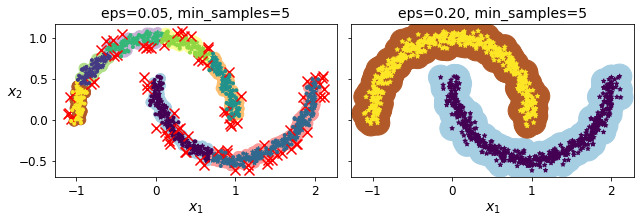

In [18]:
# Plot
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


**Somewhat surprisingly, the DBSCAN class does not have a predict() method, although it has a fit_predict() method. In other words, it cannot predict which cluster a new instance belongs to. This implementation decision was made because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. Moreover, it’s not hard to implement. For example, let’s train a KNeighborsClassifier:**

In [20]:
# Set dbscan = dbscan2
dbscan = dbscan2

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# KNN model and train the classifier on the core instances only
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [25]:
# Now, given a few new instances, we can predict which cluster they most likely
# belong to and even estimate a probability for each cluster:

# New instances
X_new = np.array([
                  [-0.5, 0],
                  [0, 0.5],
                  [1, -0.1],
                  [2, 1]])

# Predict
result = knn.predict(X_new)

for Xi, yi in zip(X_new, result):
  print( Xi, ' in cluster ', yi )

[-0.5  0. ]  in cluster  1
[0.  0.5]  in cluster  0
[ 1.  -0.1]  in cluster  1
[2. 1.]  in cluster  0


In [29]:
# And the predictions with probability
result = knn.predict_proba(X_new)

for Xi, yi in zip(X_new, result):
  print( 'Instance', Xi, ' in these clusters with probabilitie of ', yi )

Instance [-0.5  0. ]  in these clusters with probabilitie of  [0.18 0.82]
Instance [0.  0.5]  in these clusters with probabilitie of  [1. 0.]
Instance [ 1.  -0.1]  in these clusters with probabilitie of  [0.12 0.88]
Instance [2. 1.]  in these clusters with probabilitie of  [1. 0.]


**Note that** we only trained the classifier on the core instances, but we could also have chosen to train it on all the instances, or all but the anomalies: this choice depends on the final task.

**The decision boundary is represented in Figure below (the crosses represent the four instances in X_new). Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. It is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, use the kneighbors() method of the KNeighborsClassifier. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):**

In [31]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    plot_data(X)
    
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure cluster_classification_plot


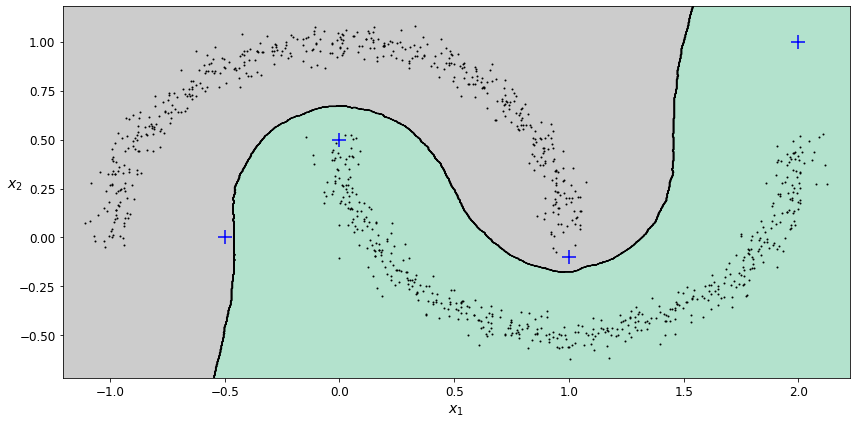

In [32]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [33]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

**In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters (eps and min_samples). If the density varies significantly across the clusters, however, it can be impossible for it to capture all the clusters properly. Its computational complexity is roughly O(m log m), making it pretty close to linear with regard to the number of instances, but Scikit-Learn’s implementation can require up to O(m2) memory if eps is large.**

**TIP:**

You may also want to try Hierarchical DBSCAN (HDBSCAN), which is implemented in the scikit-learn-contrib project.